In [1]:
import sys
sys.path.append("./simulation/")

#from util import *
import os, shutil
import pandas as pd
from datetime import datetime

from opmap.cmap import bipolar
from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.phaseMapFTDT import PhaseMapFTDT
from opmap.phaseVarianceMap import PhaseVarianceMap
from opmap.phaseMapEvent import PhaseMapEvent
from opmap.f_pixel import f_pixel_diff_thre
from opmap.util import phaseComplement


from elecpy.elecpySession import ElecpySession

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm
import copy

%matplotlib inline


from opmap.util import phaseComplement

In [2]:
src_dir = '/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/'
save_dir = '/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/'
print(save_dir)
if not os.path.exists(save_dir) : os.mkdir(save_dir)

/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/


In [3]:
def analyzeSession(sess, save_dir=None):
    
    vmem = VideoData(*sess.data['vmem'].shape)
    vmem.data = sess.data['vmem']
    vmem.cmap = bipolar(neutral=0, lutsize=1024)
    vmem.vmin = sess.data['vmem'].min()
    vmem.vmax = sess.data['vmem'].max()
    
    p_diff = PhaseMapEvent(vmem, width = vmem.data.shape[2], f_event=f_pixel_diff_thre, diff_thre = 5, inter_min = 5)

    p_ftdt = PhaseMapFTDT(vmem, width = vmem.data.shape[2], v_mean = -60.0, dt = 10);
    #p_ftdt.draw_phase_portrait(pos_x=150,pos_y=150)
    #return
    
    p_hilbert = PhaseMapHilbert(vmem, width = vmem.data.shape[2], sigma_xy=1, sigma_t=1);

    pv_diff    = PhaseVarianceMap(p_diff, size=3)
    pv_ftdt    = PhaseVarianceMap(p_ftdt, size=3)
    pv_hilbert = PhaseVarianceMap(p_hilbert, size=3)
    
    sess.data['p_diff'] = p_diff.data
    sess.data['p_ftdt'] = p_ftdt.data
    sess.data['p_hilbert'] = p_hilbert.data
    
    sess.data['pv_diff'] = pv_diff.data
    sess.data['pv_ftdt'] = pv_ftdt.data
    sess.data['pv_hilbert'] = pv_hilbert.data
    
    sess.data['hilbert_mean'] = p_hilbert.Vmean
    
    if save_dir is not None:
        vmem.saveImage( os.path.join(save_dir, 'vmem'))
        p_diff.saveImage( os.path.join(save_dir, 'p_diff'))
        p_ftdt.saveImage( os.path.join(save_dir, 'p_ftdt'))
        p_hilbert.saveImage( os.path.join(save_dir, 'p_hilbert'))
        pv_diff.saveImage( os.path.join(save_dir, 'pv_diff'))
        pv_ftdt.saveImage( os.path.join(save_dir, 'pv_ftdt'))
        pv_hilbert.saveImage( os.path.join(save_dir, 'pv_hilbert'))
        


In [4]:
def plot_phase(times, phase_trans, **kwargs):
    arr = np.where(np.abs(phase_trans[1:]-phase_trans[:-1]) > np.pi)[0]
    terms = np.concatenate([np.array([0]), arr+1, np.array([len(phase_trans)])])
    for i, start in enumerate(terms[:-1]):
        end = terms[i+1]
        plt.plot( times[start:end], phase_trans[start:end], **kwargs)

# P = phaseComplement( np.arange(100)*(0.02*np.pi))
# plt.plot(np.arange(len(P)), P, c='k', linestyle='dotted')
# plot_phase(np.arange(len(P)), P, c='k', linestyle='solid')
    

In [5]:
### Vmem(raw) ###
def save_vmem(sess):
    
    path = os.path.join(dst_dir,'vmem_raw')
    if not os.path.exists(path) : os.mkdir(path)
    vmin = sess.data['vmem'].min()
    vmax = sess.data['vmem'].max()
    for f, vmem in enumerate(sess.data['vmem']):
        plt.imsave(
            os.path.join(path, '{0:0>4}.png'.format(f)), 
            vmem, 
            cmap=bipolar(neutral=0, lutsize=1024),
            vmin=vmin, vmax=vmax)

In [6]:
### 3D phase plot ###
def plot_phase_3d(sess, phase_type):
    
    cut_thre = 2*np.pi*0.75
    p = sess.data[phase_type]
    
    for view_angle in range(4):

        path = os.path.join(dst_dir,'{0}/psurf_{1}'.format(phase_type, view_angle))
        print(path)
        if not os.path.exists(path) : os.mkdir(path); 

        for frame in range(row.f_max-row.f_min):

            plt.clf()
    
            fig = plt.figure(figsize=(15,10))
            ax = fig.add_subplot(111, projection='3d')
            ax.set_zlim3d(-np.pi, np.pi)

            _, size_h, size_w = p.shape

            y = np.arange(size_h)
            x = np.arange(size_w)
            X, Y = np.meshgrid(x, y)
            Z = p[frame, ::-1, :]

            if view_angle is 1: Z = Z.T[:,::-1]
            if view_angle is 2: Z = Z[::-1,::-1]
            if view_angle is 3: Z = Z.T[::-1,:]

            wire = ax.plot_wireframe(X, Y, Z)

            nx, ny, _  = np.shape(wire._segments3d)
            wire_x = np.array(wire._segments3d)[:, :, 0].ravel()
            wire_y = np.array(wire._segments3d)[:, :, 1].ravel()
            wire_z = np.array(wire._segments3d)[:, :, 2].ravel()
            wire.remove()

            # create data for a LineCollection
            wire_x1 = np.vstack([wire_x, np.roll(wire_x, 1)])
            wire_y1 = np.vstack([wire_y, np.roll(wire_y, 1)])
            wire_z1 = np.vstack([wire_z, np.roll(wire_z, 1)])

            to_delete = np.arange(0, nx*ny, ny)
            wire_x1 = np.delete(wire_x1, to_delete, axis=1)
            wire_y1 = np.delete(wire_y1, to_delete, axis=1)
            wire_z1 = np.delete(wire_z1, to_delete, axis=1)
            scalars = np.delete(wire_z, to_delete)

            segs = np.array([list(zip(xl, yl, zl)) for xl, yl, zl in \
                         zip(wire_x1.T, wire_y1.T, wire_z1.T)])

            # delete false phase discontinuity
            to_delete = np.where( np.array([ abs( seg[0][2] - seg[1][2]) for seg in segs ]) > cut_thre)[0]
            segs = np.delete( segs, to_delete, axis=0)
            scalars = np.delete( scalars, to_delete)

            # Plots the wireframe by a  a line3DCollection
            my_wire = art3d.Line3DCollection(segs, cmap="jet")
            my_wire.set_array(scalars)
            my_wire.set_clim(vmin=-np.pi, vmax=np.pi)
            ax.add_collection(my_wire)

            plt.colorbar(my_wire)
            plt.savefig(os.path.join(path, '{0:0>6}.png'.format(frame)))

In [7]:

### integral of time differential ###
def plot_phase_integral(sess, phase_type):
    
    path = os.path.join(dst_dir,'{0}'.format(phase_type))
    print(path)
    if not os.path.exists(path) : os.mkdir(path); 

    p = sess.data[phase_type]
    v = sess.data['vmem']
    pdiff = copy.deepcopy(p)
    for f in range(len(pdiff)):
        if f == 0: 
            pdiff[f,:,:] = 0
        else:
            pdiff[f,:,:] = p[f,:,:] - p[f-1,:,:]
    pdiff = phaseComplement(pdiff)
    pinteg = abs(np.sum(pdiff, axis=0))

    plt.clf()
    plt.imshow(pinteg, vmin=0, cmap='gray') # vmax=2*np.pi, 
    plt.colorbar()
    plt.savefig(os.path.join(path, 'pinteg.png'))
    
    
    ## plot vmem of pos/neg areas
    pos_y, pos_x = np.where(pinteg > thre_phase_integ)
    neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
    
    plt.clf()
    plt.subplot(2,2,1)
    for y, x in zip(neg_y, neg_x):
        if x == p.shape[2]//2:
            plt.plot(v[:,y,x], 'b')
            plt.ylim([v.min(), 20])
    plt.subplot(2,2,2)
    for y, x in zip(neg_y, neg_x):
        if x == p.shape[2]//2:
            plt.plot(p[:,y,x], 'b')
            plt.ylim([-np.pi, np.pi])
    plt.subplot(2,2,3)
    for y, x in zip(pos_y, pos_x):
        if x == p.shape[2]//2:
            plt.plot(v[:,y,x], 'r')
            plt.ylim([v.min(), 20])
    plt.subplot(2,2,4)
    for y, x in zip(pos_y, pos_x):
        if x == p.shape[2]//2:
            plt.plot(p[:,y,x], 'r')
            plt.ylim([-np.pi, np.pi])
    plt.savefig(os.path.join(path, 'border_plot.png'))
    plt.close()



In [8]:
### phase graph (circular plot) ###
def plot_circular_phase(sess, phase_type, thre_phase_integ):
    path = os.path.join(dst_dir,'border_plot')
    if not os.path.exists(path) : os.mkdir(path)
        
    
    for f in range(len(p)):

        plt.figure(figsize=(5,5))
        plt.clf()

        phases = np.arange(0,2*np.pi,np.pi/1024)
        plt.scatter( np.cos(phases), np.sin(phases), c='k', s=.02)

        A = np.arange(-1.2, 1.2, 0.01)
        plt.scatter( A, np.zeros_like(A), c='k', s=.02)
        plt.scatter( np.zeros_like(A), A, c='k', s=.02)

        pos_y, pos_x = np.where(pinteg > thre_phase_integ)
        for y, x in zip(pos_y, pos_x):
            if x == p.shape[2]//2:
                phases = p[f,y,x]
                plt.scatter( np.cos(phases), np.sin(phases), c='r', s=10)

        neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
        for y, x in zip(neg_y, neg_x):
            if x == p.shape[2]//2:
                phases = p[f,y,x]
                plt.scatter( np.cos(phases), np.sin(phases), c='b', s=10)

        plt.axis('equal')
        plt.axis([-1.2, 1.2, -1.2, 1.2])
        plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
        plt.close()

In [9]:
### spatial phase polarity ###
def plot_phase_polarity(sess, phase_type):
    
    path = os.path.join(dst_dir,'{0}/polarity'.format(phase_type))
    print(path)
    if not os.path.exists(path) : os.mkdir(path)

    p = sess.data[phase_type]
    H = p.shape[1]
    W = p.shape[2]
    pdiff_x = np.zeros(( H  , W-1))
    pdiff_y = np.zeros(( H-1, W  ))
    plt.clf()

    for f in range(len(p)):

        plt.clf()
        fig, ax = plt.subplots(figsize=(10,10))
        plt.axis('equal')
        ax = plt.gca()
        plt.axis([0, H, 0, W])
        ax.tick_params(labelbottom="off", labelleft="off")
        ax.tick_params(bottom="off", left="off")
        ax.tick_params(top="off", right="off")
        ax.axis("off")
        #plt.style.use('dark_background')

        #plt.subplot(121)
        #plt.imshow(p[f], cmap='jet', vmin=-np.pi, vmax=np.pi)
        #plt.subplot(122)
        cm = bipolar(neutral=0, lutsize=1024)
        pdiff_y = p[f,1:,:] - p[f,:-1,:]
        pdiff_x = p[f,:,1:] - p[f,:,:-1]

        plt.plot( [0,0,W,W,0], [0,H,H,0,0], linewidth=5, color='black')

        for j in range(W-1):

            x = np.ones(H+1)*(j+1)
            y = np.arange(H+1)

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = mcoll.LineCollection(
                segments, array=-np.cos(pdiff_x[::-1,j]), 
                cmap=plt.cm.binary_r, 
                norm=plt.Normalize(-1.25, 1.0),
                linewidth=5, alpha=1.0)
            ax.add_collection(lc)

        for i in range(H-1):

            y = np.ones(W+1)*(i+1)
            x = np.arange(W+1)

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = mcoll.LineCollection(
                segments, 
                array=-np.cos(pdiff_y[-1-i,:]), 
                cmap=plt.cm.binary_r, 
                norm=plt.Normalize(-1.25, 1.0),
                linewidth=5, alpha=1.0)
            ax.add_collection(lc)    

        plt.savefig(
            os.path.join(path, '{0:0>6}.png'.format(f)),
            transparent=True, 
            bbox_inches='tight'
        )
        plt.close()


In [10]:
### Trajectory ###
import math

def plot_pv_traj(sess, phase_type):
    
    pv_type = phase_type.replace('_', 'v_')
    
    path = os.path.join(dst_dir,'{0}'.format(phase_type))
    print(path)
    if not os.path.exists(path) : os.mkdir(path)

    pv_thre= 1 - math.sqrt( -math.log(0.05) / ( 3**2) )

    plt.clf()
    plt.imshow( ( np.sum((sess.data[pv_type]>pv_thre)*1, axis=0) > 0)*1, cmap='gray')
    plt.colorbar()
    plt.savefig(os.path.join(path, 'traj.png'))


In [25]:
df_whole = pd.read_csv('data.whole.csv')
df_whole

,sim_id,gna,gkr,gks,description
0,20190226-3,12.0,0.0125,0.13860,pinning (short WL & lateralization) <<< 20190...
1,20180625-1,15.6,0.0088,0.09702,APD prolongation <<< 20171128-1
2,20180616-1,10.0,0.0125,0.13860,vortex shedding <<< 20171128-1


In [12]:
df_region = pd.read_csv('data.roi.csv')
df_region

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20190226-3,130,170,120,160,1700,1740,A,pinning
1,20180625-1,110,150,80,120,120,160,C,meandering
2,20180625-1,160,200,80,120,225,265,D,spiral stop
3,20180616-1,80,120,80,120,360,400,B,over the trajectory of vortex shedding


## Check whole dynamics

In [46]:
print datetime.now().strftime("%Y/%m/%d %H:%M:%S")

for i, row in df_whole.iterrows():
    
    if i not in [1]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    print(os.path.join(src_dir, row.sim_id))
    sess = ElecpySession( os.path.join(src_dir, row.sim_id), keys=['vmem'])
    
    #analyzeSession(sess, save_dir=dst_dir)
    analyzeSession(sess)
    #continue
    
    #plt.imshow(np.sum(sess.data['pv'][100:-100,:,:] > 0.3, axis=0), cmap='gray')
    #plt.savefig(os.path.join(dst_dir, 'traj.png'))
    

2019/04/02 17:12:24
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20180625-1
/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20180625-1


### Plot different phase types

2019/04/02 17:13:34


(-3.5, 3.5)

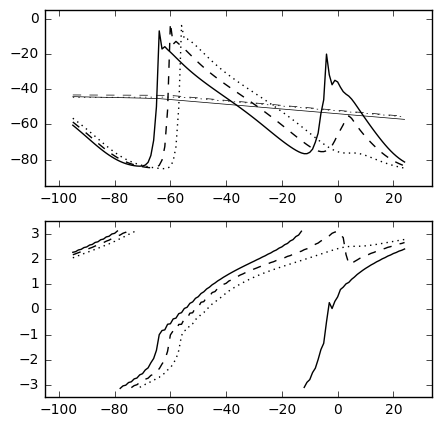

In [47]:
print datetime.now().strftime("%Y/%m/%d %H:%M:%S")

# 20190226-3 (A)
# points = [(144,150), (150,150)]#,  (110, 100)]
# f_start, f_end = (1650,1800)
# times = np.arange(f_start, f_end) - 1712 #offset 

# 20180616-1 (B)
# points = [(97, 100),(100, 100), (103,100)]#,  (110, 100)]
# f_start, f_end = (300,500)
# times = np.arange(f_start, f_end) - 360 #offset 
# linestyles = ['dotted', 'dashed', 'solid']

# 20180625-1 (C)
# points = [(103, 132),(106, 132),(109, 132)]
# f_start, f_end = (75,225)
# times = np.arange(f_start, f_end) - 140
# linestyles = ['dotted', 'dashed', 'solid']

# 20180625-1 (D)
points = [(98, 195),(101, 195),(104, 195),]
f_start, f_end = (150,270)
times = np.arange(f_start, f_end) - 245 #offset 
linestyles = ['dotted', 'dashed', 'solid']

if len(points) is 2:
    linestyles = ['dashed', 'solid']
elif len(points) is 3:
    linestyles = ['dotted', 'dashed', 'solid']


plt.subplots_adjust(wspace=0.4, hspace=1.2)

col = 'k'
markers = ['o' for p in points]
point_names = 'abc'

plt.figure(figsize=(5,5))

plt.subplot(211);
for i, (py, px) in enumerate(points): 
    plt.plot( times, sess.data['vmem'][f_start:f_end,py,px], 
             c=col, linestyle=linestyles[i], label=point_names[i]);
    plt.plot( times, sess.data['hilbert_mean'][f_start:f_end,py,px],
             c=col, linestyle=linestyles[i], linewidth=0.5);
plt.xlim((times.min()-10, times.max()+10))
plt.ylim((-95, 5))

#plt.title('Vm')
#plt.legend(loc='upper right')

if False:
    plt.subplot(312); 
    for i, (py, px) in enumerate(points): 
        # plt.plot( sess.data['p_diff'][f_start:f_end,py,px],
        plot_phase( times, sess.data['p_diff'][f_start:f_end,py,px],
                  c=col, linestyle=linestyles[i])#, label=point_names[i]);
    plt.title('event-based phase')
    plt.legend(loc='upper right')
    plt.xlim((times.min()-10, times.max()+10))
    plt.ylim((-3.5, 3.5))

#plt.subplot(413); plt.plot( sess.data['p_ftdt'][f_start:f_end,py,px] )
plt.subplot(212); 
for i, (py, px) in enumerate(points): 
    #plt.plot( sess.data['p_hilbert'][f_start:f_end,py,px],
    plot_phase( times, sess.data['p_hilbert'][f_start:f_end,py,px],
              c=col, linestyle=linestyles[i])#, label=point_names[i]);
#plt.title('value-based phase')
plt.legend(loc='upper right')
plt.xlim((times.min()-10, times.max()+10))
plt.ylim((-3.5, 3.5))


In [33]:
sess.data['vmem'].max(), sess.data['vmem'].min()

(7.4008082099177814, -87.459475429388448)

## Check region detail

In [17]:
thre_phase_integ = np.pi*1.0

2019/03/24 13:34:18
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740
('cell/xina', 2001, 2001)
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_diff
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_diff
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_diff/polarity
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_diff
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_ftdt
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_ftdt
/mnt/Omer/Project/01.PhaseDiscontinuity/AnalysisResults/2019-02-25/20190226-3/x130-170_y120-160_f1700-1740/p_ftdt/polarity
/mnt/Omer/Project/01.PhaseDisco

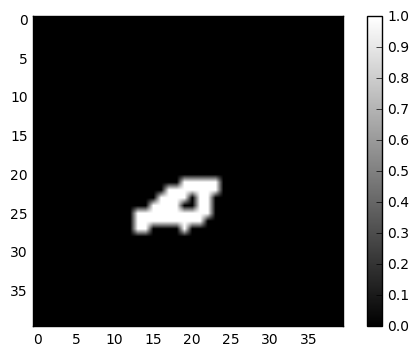

In [29]:
print datetime.now().strftime("%Y/%m/%d %H:%M:%S")

for i, row in df_region.iterrows():
    
    if i not in [0]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    
    sess = ElecpySession(os.path.join(src_dir, row.sim_id), keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max
    )
    
    analyzeSession(sess, save_dir=dst_dir)    
    #save_vmem(sess); continue
    
    sess.setRange(
        f_min = row.f_min,
        f_max = row.f_max,
    )
    
    phase_types = ['p_diff', 'p_ftdt', 'p_hilbert']#, 
    for phase_type in phase_types:
        path = os.path.join(dst_dir,'{0}'.format(phase_type))
        print(path)
        if not os.path.exists(path) : os.mkdir(path)
        
        #plot_phase_3d(sess, phase_type)
        plot_phase_integral(sess, phase_type)
        plot_phase_polarity(sess,phase_type)
        plot_pv_traj(sess, phase_type)

## Total sodium current

In [ ]:
df = pd.read_csv('data.roi-Ina.csv')
df

In [ ]:
for i, row in df.iterrows():
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    
    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max,
        f_min = row.f_min,
        f_max = row.f_max,
    )

    
    ### Sodium current integral ###
    
    xina = abs(np.sum(sess.data["cell/xina"], axis=0))
    plt.clf()
    plt.imshow(xina, cmap='gray')
    plt.colorbar()
    plt.savefig(os.path.join(dst_dir, 'xina.png'))
    

## Shift speed analysis

In [ ]:
r = 5

In [ ]:
df = pd.read_csv('data.roi-speed.csv')
df

In [ ]:
def lkf2d(Y):

    A = np.eye(4)
    A[0,2] = 1.
    A[1,3] = 1.
    B = np.eye(4)
    Q = np.eye(4)
    C = np.eye(4)
    R = np.eye(4)*2.0
    C = np.eye(4)
    R = np.eye(4)

    Sigma = np.zeros((4,4))
    mu = Y[0]
    M = [mu]

    for i in range(1,len(Y),1):

        # 推定
        mu_ = np.dot(A, mu) #+ np.dot(B, U[i])
        Sigma_ = Q + np.dot(np.dot(A , Sigma) , A.T)

        # 更新
        yi = Y[i][:,np.newaxis] - np.dot(C , mu_)
        S = np.dot(np.dot(C , Sigma_), C.T) + R
        K = np.dot(np.dot(Sigma_ , C.T) , np.linalg.inv(S))
        mu = mu_ + np.dot( K , yi )
        Sigma = Sigma_ - np.dot( np.dot(K , C) , Sigma_)
        M.append(mu[:,0])

    M = np.array(M)
    return M


In [ ]:
for i, row in df.iterrows():
    
    if not i in [4]: continue
        
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)


    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max
    )

    analyzeSession(sess)
    sess.setRange(
        f_min = row.f_min,
        f_max = row.f_max,
    )

In [ ]:
pv=sess.data['pv']
p = sess.data['phase']
L,H,W=pv.shape

traj = np.array([ np.unravel_index(im.argmax(), im.shape) for im in pv])
tran = traj[1:,:] - traj[:-1,:]
#speed = np.linalg.norm((tran[1:,:] + tran[:-1,:])/2., axis=1)

Y = np.concatenate( (traj[:-1,:], tran ), axis=1)
M = lkf2d(Y)
speed = np.linalg.norm( M[:,2:], axis=1)


## bipolarity on center
path = os.path.join(dst_dir,'polarity_center')
path_t = os.path.join(dst_dir,'trajectory')
if not os.path.exists(path) : os.mkdir(path)
if not os.path.exists(path_t) : os.mkdir(path_t)
out = []
for f, im in enumerate(pv):

    gy, gx = traj[f,:]
    #print((gx, gy))

    if (gy-r) < 0 or (gx-r) < 0 or (gy+r) > H or (gx+r) > W or f <= 0 or f >= len(pv)-1: continue

    pdiff_x = (p[f,:,gx-r+1:gx+r] - p[f,:,gx-r:gx+r-1])[gy-r:gy+r,:]
    pdiff_y = (p[f,gy-r+1:gy+r,:] - p[f,gy-r:gy+r-1,:])[:,gx-r:gx+r]

    ## mean bipolarity
    thre = -np.cos(np.pi-.8*np.pi)
    pdiff = np.concatenate( (pdiff_x.flatten(),pdiff_y.flatten()), axis=0)
    B = -np.cos(pdiff)
    l = np.mean( B )
    out.append( [speed[f-1], l ])
    
    ## plot trajecory
    plt.clf()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.axis('equal')
    ax = plt.gca()
    plt.axis([0, H, 0, W])
    #ax.tick_params(labelbottom="off", labelleft="off")
    #ax.tick_params(bottom="off", left="off")
    #ax.tick_params(top="off", right="off")
    #ax.axis("off")
    
    f_start = max(f-30, 0)
    gys = traj[f_start:f, 0]
    gxs = traj[f_start:f, 1]
    plt.scatter(gxs, gys, 
        c = np.arange(f_start, f),
        norm=plt.Normalize(f_start, f),
        cmap=plt.cm.jet, 
        linewidth=1)

    plt.savefig(
        os.path.join(path_t, '{0:0>6}.png'.format(f)),
        transparent=True, 
        bbox_inches='tight'
    )
    #plt.show()
    plt.close()
    continue


    # plot edges
    plt.clf()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.axis('equal')
    ax = plt.gca()
    #ax = fig.add_subplot(1,1,1, axisbg='black')
    ax.tick_params(labelbottom="off", labelleft="off")
    ax.tick_params(bottom="off", left="off")
    ax.tick_params(top="off", right="off")
    ax.axis("off")
    plt.plot( [gx-r,gx-r,gx+r,gx+r,gx-r], [gy-r,gy+r,gy+r,gy-r,gy-r], linewidth=5, color='black')

    for j in range(gx-r, gx+r-1):

        x = np.ones(2*r+1)*(j+1)
        y = np.arange(gy-r, gy+r+1, 1)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = mcoll.LineCollection(
            segments, array=-np.cos(pdiff_x[::-1,j-(gx-r)]), 
            cmap=plt.cm.coolwarm, 
            norm=plt.Normalize(-1.25, 1.0),
            linewidth=5, alpha=1.0)
        ax.add_collection(lc)

    for i in range(gy-r, gy+r-1):

        y = np.ones(2*r+1)*(i+1)
        x = np.arange(gx-r, gx+r+1, 1)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = mcoll.LineCollection(
            segments, 
            array=-np.cos(pdiff_y[-1-(i-(gy-r)),:]), 
            cmap=plt.cm.coolwarm, 
            norm=plt.Normalize(-1.25, 1.0),
            linewidth=5, alpha=1.0)
        ax.add_collection(lc)    

    plt.savefig(
        os.path.join(path, '{0:0>6}.png'.format(f)),
        transparent=True, 
        bbox_inches='tight', 
        facecolor=fig.get_facecolor(),
    )
    #plt.show()
    plt.close()

In [ ]:
len(traj)

In [ ]:
## mean bipolarity vs. SW speed 
out = np.array(out)
x = out[:,0]
y = out[:,1]

ax = plt.gca()#.set_aspect('equal', adjustable='box')
#ax.set_aspect('equal')

xmin = x.min() - (x.max()-x.min())*0.1
xmax = x.max() + (x.max()-x.min())*0.1
ymin = y.min() - (y.max()-y.min())*0.1
ymax = y.max() + (y.max()-y.min())*0.1

ax.axis([xmin, xmax, ymin, ymax])
ax.scatter(x,y, c='k', s=5)

print(np.corrcoef(x,y)[0,1])

a, b = np.polyfit(x,y,1)
xs = np.arange(xmin, xmax, (xmax-xmin)*0.01)
y2 = a*xs+b
ax.plot(xs, y2, c='r')

plt.show()

## Misc

In [ ]:

plt.clf()

fig, ax = plt.subplots(figsize=(5,5))
plt.axis('equal')
plt.axis([-1.2, 1.2, -1.2, 1.2])
ax = plt.gca()
ax.tick_params(labelbottom="off", labelleft="off")
ax.tick_params(bottom="off", left="off")
ax.tick_params(top="off", right="off")
ax.axis("off")

phases = np.arange(0,2*np.pi,np.pi/1024)
plt.scatter( np.cos(phases), np.sin(phases), c='k', s=.02)

A = np.arange(-1.2, 1.2, 0.01)
plt.scatter( A, np.zeros_like(A), c='k', s=.02)
plt.scatter( np.zeros_like(A), A, c='k', s=.02)

phases = np.arange(0,2*np.pi,np.pi/16)
plt.scatter( 
    np.cos(phases), np.sin(phases), 
    c=-np.cos(phases), 
    cmap=plt.cm.coolwarm,
    s=10)

segments = np.array( [[[0,0],[np.cos(theta), np.sin(theta)]] for theta in phases], dtype=np.float64)
lc = mcoll.LineCollection(
    segments, array=-np.cos(phases), 
    cmap=plt.cm.coolwarm, 
    norm=plt.Normalize(-1.0, 1.0),
    linewidth=1, alpha=1.0)
ax.add_collection(lc)

plt.show()

#plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
#plt.close()

In [59]:
def plot_phase_without_warp(data, **kwargs):
    
    data_diff = np.copy(data)
    data_diff[0] = 0
    data_diff[1:] = data_diff[1:] - data[:-1]
    
    warps = np.where(np.abs(data_diff)>np.pi)
    warps = np.concatenate([[0],warps[0],[len(data_diff)-1]])
    print warps
    
    for i, w in enumerate(warps[1:]):
        start = warps[i]
        end = w
        plt.plot( np.arange(start, end), data[start:end], c=kwargs['c'], linestyle=kwargs['linestyle'], label=kwargs['label']);


data = np.arange(0, 10*np.pi, 0.01*np.pi)
while(data.max() > np.pi):
    data = phaseComplement(data)
    
#plt.subplot(211)
plt.plot(data)
#plt.subplot(212)
plot_phase_without_warp(data,c='k', linestyle=linestyles[0], label=point_names[0])